In [268]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nx_comm
from mpl_toolkits.basemap import Basemap
from scipy.stats import beta, bernoulli, uniform
from geopy.geocoders import Nominatim
import geopandas as gpd
from adjustText import adjust_text
import seaborn as sns
import copy
import textwrap
import operator

In [86]:
data = pd.read_excel('/Users/summersim/Desktop/YM_meat_qtr_GTAS Forecasting__20_11_2023.xlsx')

# Remove rows where 'Start Date' is not a valid datetime string (if any)
data_cleaned = data[~data['Start Date'].astype(str).str.contains('Start Date', na=False)]

# Filter for year data where "Start Date" contains '2005'
yearly_data = data_cleaned[data_cleaned['Start Date'].astype(str).str.contains('2005')]

# Export the filtered data to a new Excel file
# output_path = '/Users/summersim/Desktop/DS/yearly_meat_data.xlsx'
# yearly_data.to_excel(output_path, index=False)#


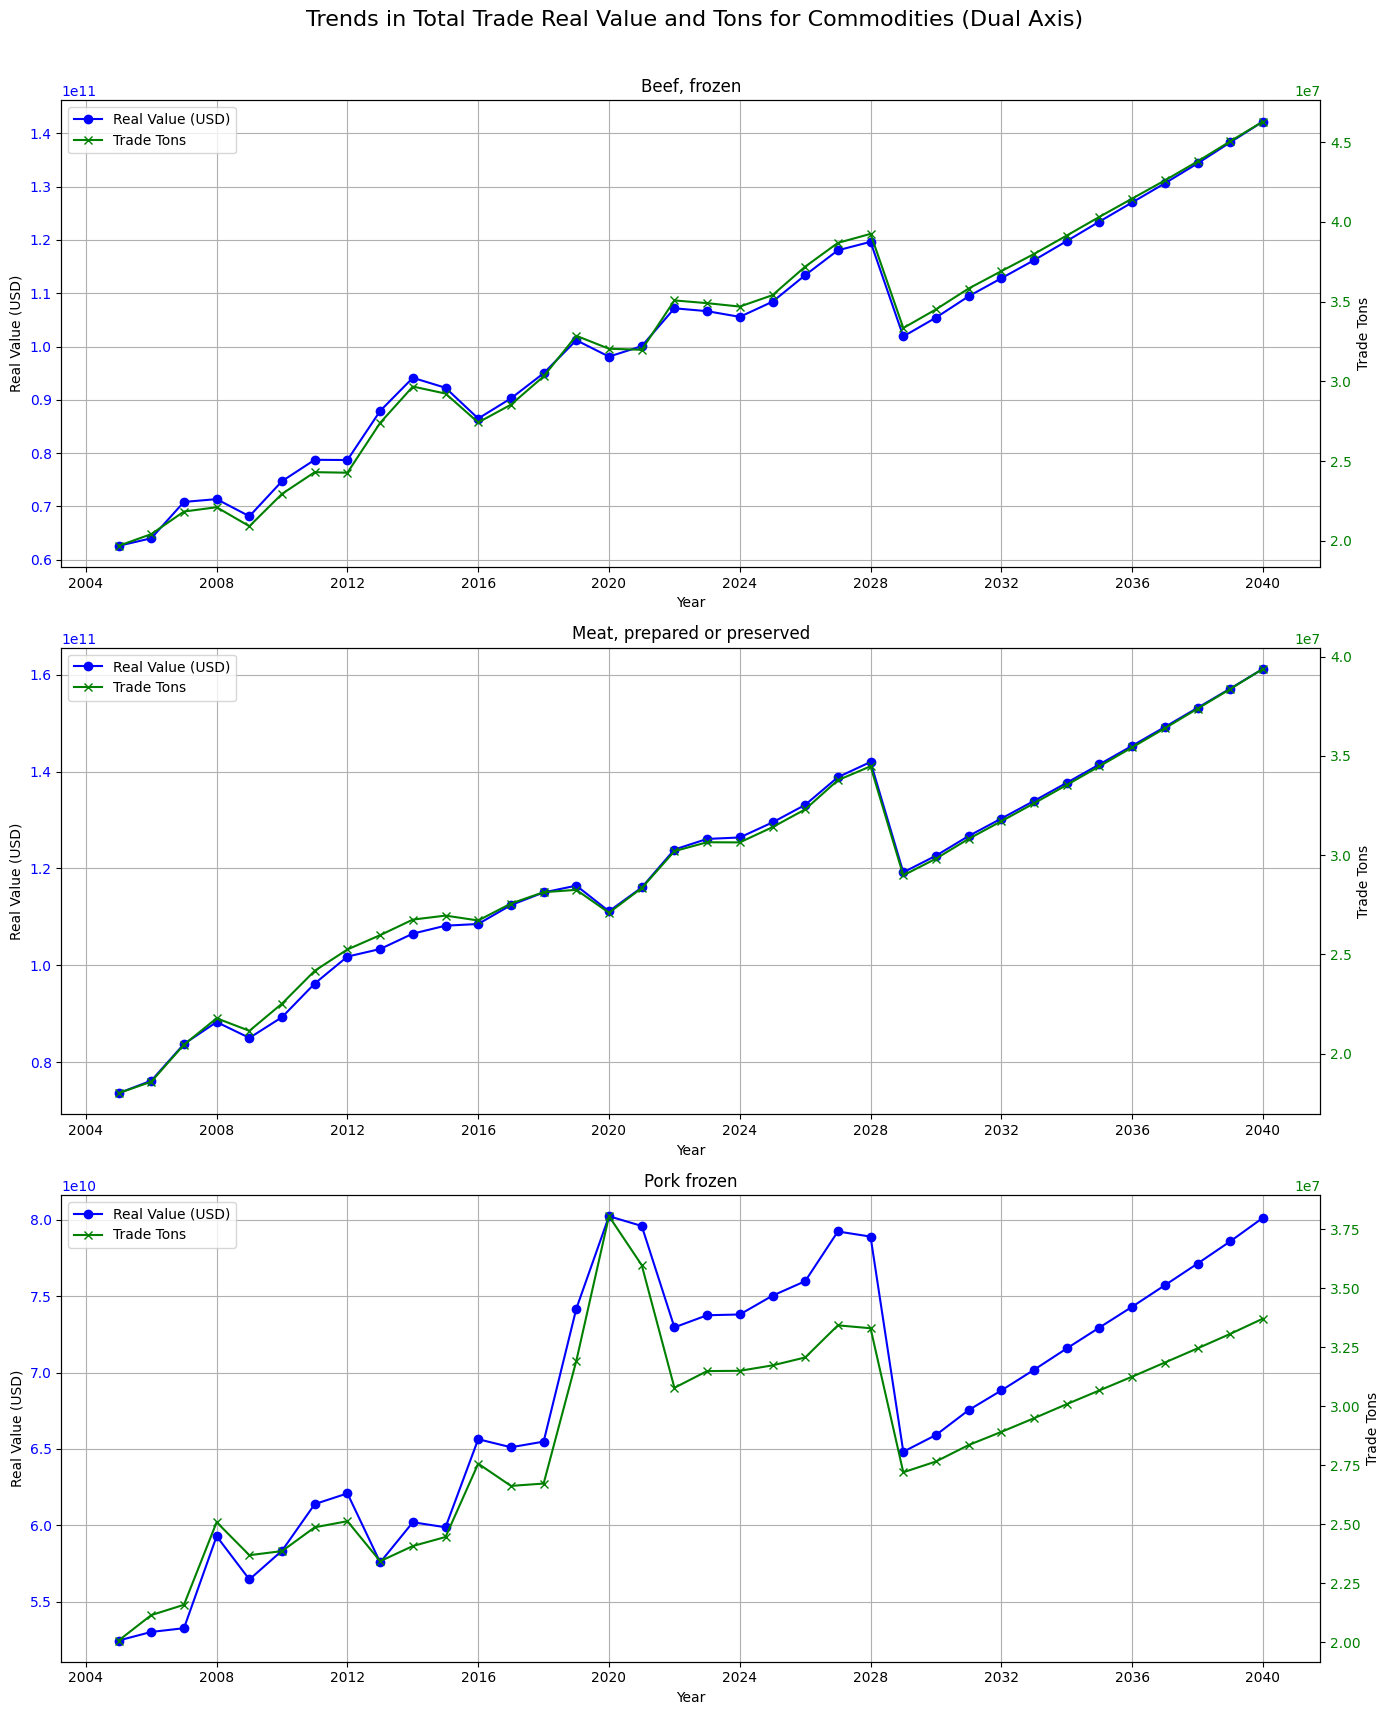

In [87]:
# Fill missing values with zero temporarily for visualization
data_filled = yearly_data.fillna(0)

# Summing up trade values by year for visualization
years_columns = data_filled.columns[6:]  # Year columns start from the 7th column

# Filter data for entries related to "Total Trade Real Value" and "Total Trade Tons"
filtered_data = data[data['Concept'].isin(['Total Trade Real Value', 'Total Trade Tons'])]

# Grouping the data by 'Commodity' and 'Concept' and summing the yearly values
grouped_data = filtered_data.groupby(['Commodity', 'Concept'])[years_columns].sum()

# Calculating the total trade over all years for each group
grouped_data['Total Trade'] = grouped_data.sum(axis=1)
grouped_data = grouped_data['Total Trade'].unstack()  # Reshape data for better visualization

# Plotting dual-axis line charts for each commodity
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 18))
fig.suptitle('Trends in Total Trade Real Value and Tons for Commodities (Dual Axis)', fontsize=16)

# Iterate over each commodity to create a plot
for i, (commodity, ax) in enumerate(zip(grouped_data.index, axes.flatten())):
    # Extract yearly data for the commodity
    commodity_data = filtered_data[(filtered_data['Commodity'] == commodity)]
    
    # Separate data by concept and sum over the years
    real_value_data = commodity_data[commodity_data['Concept'] == 'Total Trade Real Value'][years_columns].sum()
    tons_data = commodity_data[commodity_data['Concept'] == 'Total Trade Tons'][years_columns].sum()
    
    # Create line plot for real value
    ax.plot(real_value_data.index, real_value_data, label='Real Value (USD)', color='b', marker='o')
    ax.set_xlabel('Year')
    ax.set_ylabel('Real Value (USD)')
    ax.tick_params(axis='y', labelcolor='blue')
    
    # Create secondary axis for trade tons
    ax2 = ax.twinx()
    ax2.plot(tons_data.index, tons_data, label='Trade Tons', color='g', marker='x')
    ax2.set_ylabel('Trade Tons')
    ax2.tick_params(axis='y', labelcolor='green')
    
    ax.set_title(commodity)
    ax.grid(True)
    
    # Adding legends
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for the main title
plt.show()



In [165]:
# Replace 'China (mainland)' with 'China' in relevant columns
yearly_data['Import Country/Territory'] = yearly_data['Import Country/Territory'].replace('China (mainland)', 'China')
yearly_data['Export Country/Territory'] = yearly_data['Export Country/Territory'].replace('China (mainland)', 'China')

# Identify columns that are date columns from 2005 to 2022
date_columns = data_filled.columns[6:24]

# Group the data by 'Commodity', 'Import Country/Territory', 'Export Country/Territory'
# and sum the trade values for the year columns
grouped_data = yearly_data.groupby(['Commodity', 'Import Country/Territory', 'Export Country/Territory'])[date_columns].sum().reset_index()

# Filter out rows where 'Concept' is "Total Trade Value"
filtered_data_concept = yearly_data[yearly_data['Concept'] != 'Total Trade Real Value']

# Group the filtered data by 'Commodity', 'Import Country/Territory', 'Export Country/Territory'
# and sum the trade values for the year columns
grouped_data = filtered_data_concept.groupby(['Commodity', 'Import Country/Territory', 'Export Country/Territory'])[date_columns].sum().reset_index()

# Sum across the year columns to get the total trade volume
grouped_data['TotalTradeVolume'] = grouped_data[date_columns].sum(axis=1)

# Remove rows where 'Import Country/Territory' or 'Export Country/Territory' is "World Total" or "Areas, not elsewhere specified"
filtered_data = grouped_data[(grouped_data['Import Country/Territory'] != 'World Total') & 
                             (grouped_data['Export Country/Territory'] != 'World Total') &
                             (grouped_data['Import Country/Territory'] != 'Areas, not elsewhere specified') &
                             (grouped_data['Export Country/Territory'] != 'Areas, not elsewhere specified')]

# Initialize a directed graph
graphs = {}

for index, row in filtered_data.iterrows():
    commodity = row['Commodity']
    import_country = row['Import Country/Territory']
    export_country = row['Export Country/Territory']

    # Check if a graph for the commodity already exists, if not create one
    if commodity not in graphs:
        graphs[commodity] = nx.DiGraph()
    
    # Add nodes and edge to the specific commodity graph
    # Nodes are now simplified to just country names
    graphs[commodity].add_node(import_country, role='Import', commodity=commodity)
    graphs[commodity].add_node(export_country, role='Export', commodity=commodity)
    
    # Add weighted edges with commodities as attributes if needed
    graphs[commodity].add_edge(export_country, import_country, weight=row['TotalTradeVolume'], commodity=commodity)

    

/var/folders/j7/2lrdjst10q78p02rxh29kpxc0000gn/T/ipykernel_7666/2718078637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Import Country/Territory'] = yearly_data['Import Country/Territory'].replace('China (mainland)', 'China')
/var/folders/j7/2lrdjst10q78p02rxh29kpxc0000gn/T/ipykernel_7666/2718078637.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Export Country/Territory'] = yearly_data['Export Country/Territory'].replace('China (mainland)', 'China')


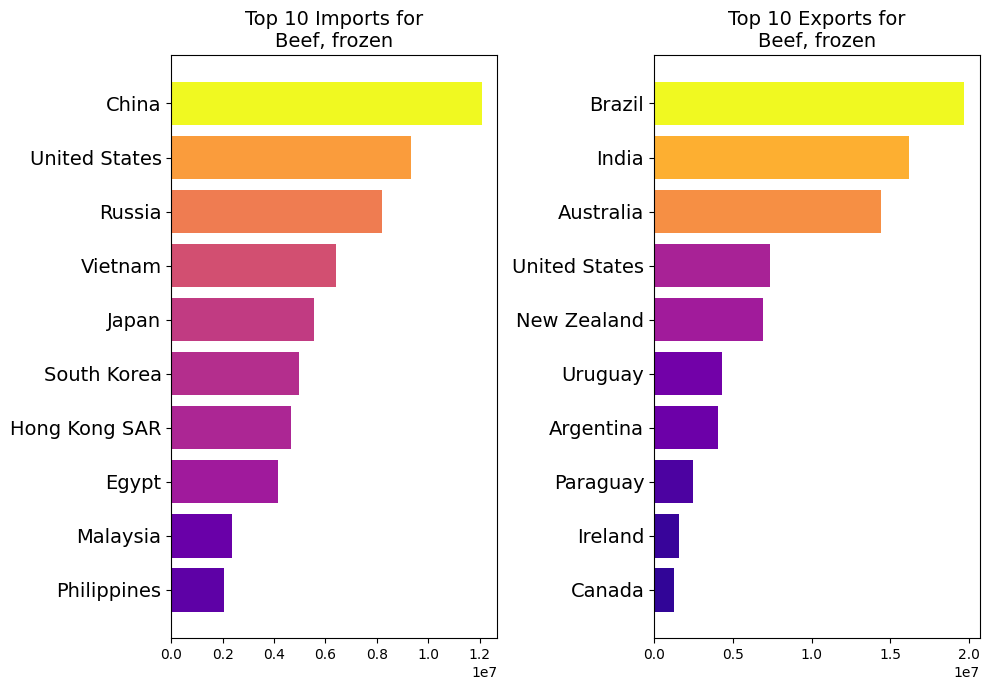

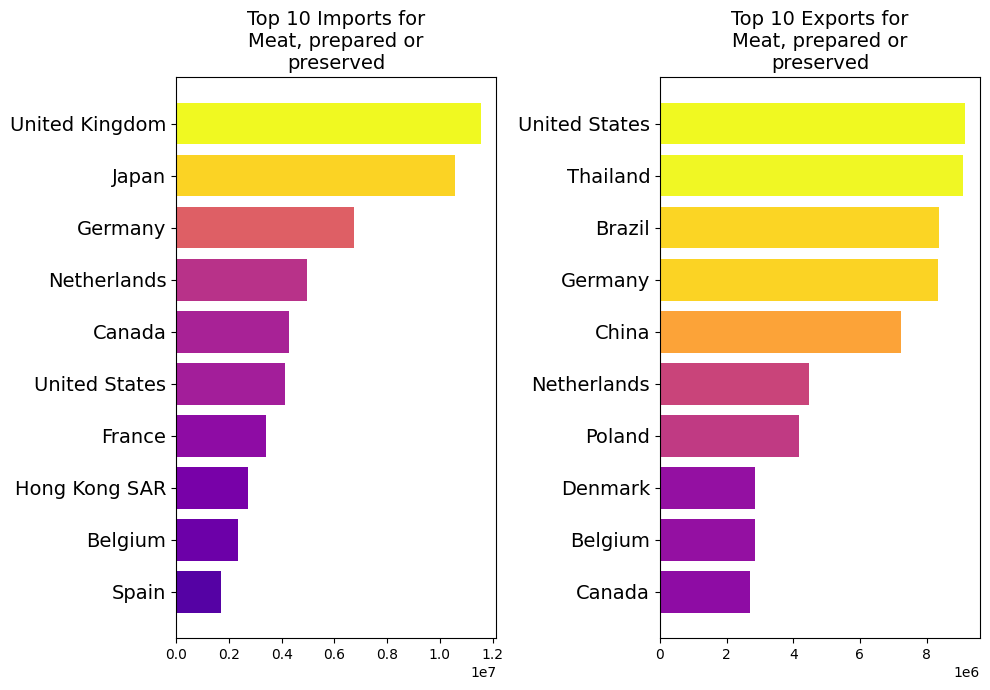

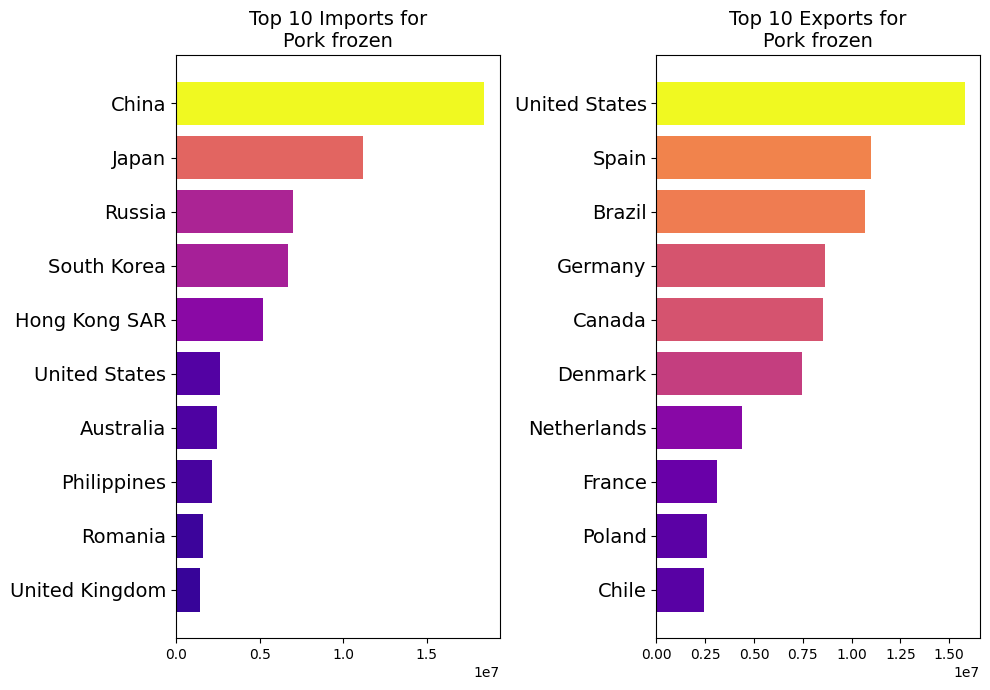

In [272]:

in_deg_cent = dict(nx.in_degree_centrality(G))
out_deg_cent = dict(nx.out_degree_centrality(G))

def draw_directed_network_with_centrality_bars(G, title=''):
    # Prepare figure
    fig, (ax_in, ax_out) = plt.subplots(1, 2, figsize=(10, 7))

    # Centrality Bar Charts
    # Calculate centrality
    in_deg_cent = dict(G.in_degree(weight='weight'))
    out_deg_cent = dict(G.out_degree(weight='weight'))

    # Sort nodes by in-degree and out-degree centrality from highest to lowest
    sorted_in_deg = sorted(in_deg_cent.items(), key=lambda x: x[1], reverse=True)
    sorted_out_deg = sorted(out_deg_cent.items(), key=lambda x: x[1], reverse=True)

    # Get the top 10 nodes
    top_in_deg = sorted_in_deg[:10]
    top_out_deg = sorted_out_deg[:10]

    # Normalize centrality for color mapping
    in_norm = [value / max(in_deg_cent.values()) for node, value in top_in_deg]
    out_norm = [value / max(out_deg_cent.values()) for node, value in top_out_deg]

    # In-Degree Centrality Bar Chart
    nodes_in, values_in = zip(*top_in_deg)
    ax_in.barh(range(len(nodes_in)), values_in, color=plt.cm.plasma(in_norm))
    ax_in.set_yticks(range(len(nodes_in)))
    ax_in.set_yticklabels(nodes_in, fontsize=14)
    ax_in.invert_yaxis()
    ax_in.set_title('\n'.join(textwrap.wrap(f'Top 10 Imports for {title}', 20)), fontsize=14)
    
    # Out-Degree Centrality Bar Chart
    nodes_out, values_out = zip(*top_out_deg)
    ax_out.barh(range(len(nodes_out)), values_out, color=plt.cm.plasma(out_norm))
    ax_out.set_yticks(range(len(nodes_out)))
    ax_out.set_yticklabels(nodes_out, fontsize=14)
    ax_out.invert_yaxis()
    ax_out.set_title('\n'.join(textwrap.wrap(f'Top 10 Exports for {title}', 20)), fontsize=14)

    plt.tight_layout()
    plt.show()

for commodity, graph in graphs.items():
    # Ensure the graph is directed
    if not graph.is_directed():
        graph = graph.to_directed()
    draw_directed_network_with_centrality_bars(graph, title=commodity)


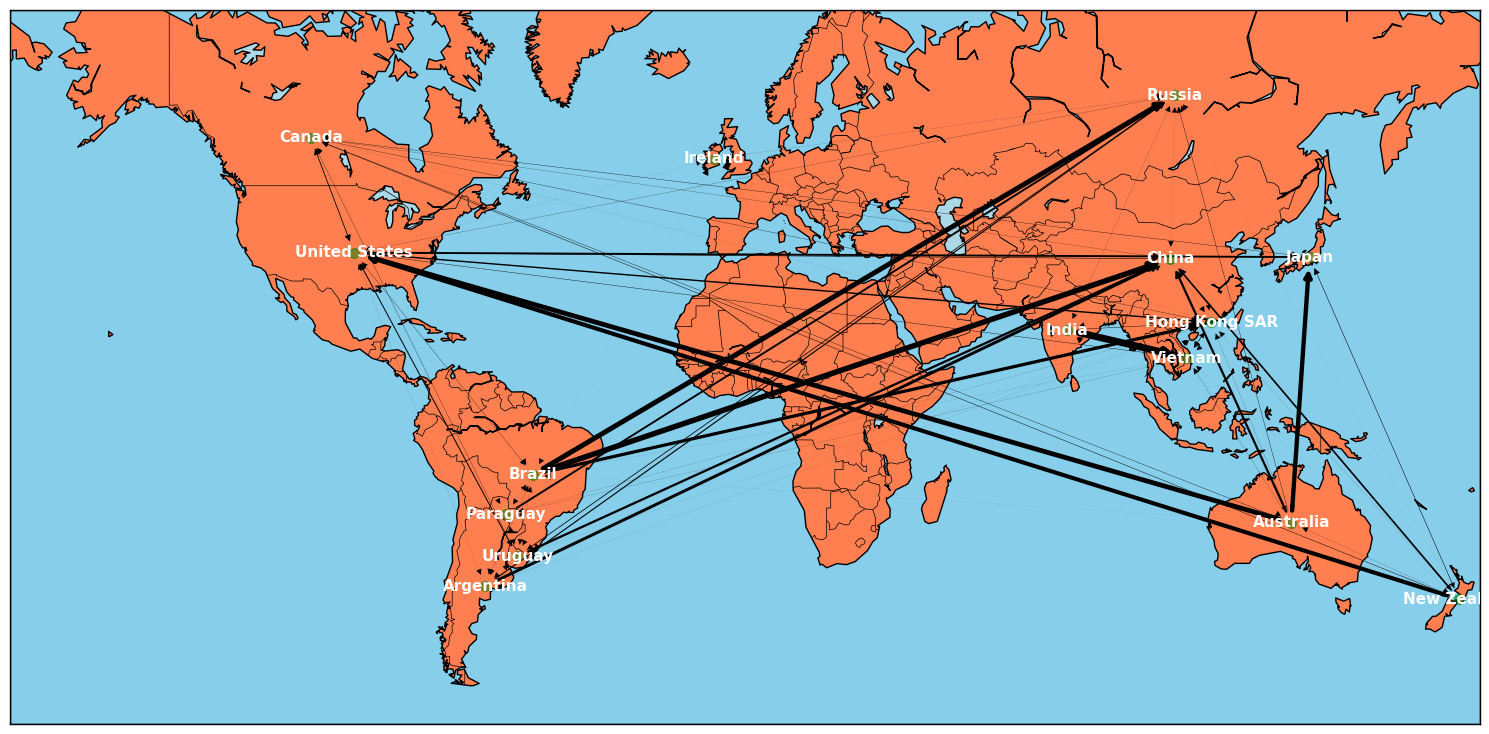

In [233]:
# Assuming 'graphs' is already defined as before
commodity = 'Beef, frozen'
G = graphs[commodity]

# Define country information
countries_df = pd.DataFrame({
    'Country': ['South Korea', 'China', 'Russia', 'Japan', 'Vietnam', 'Australia', 'United States', 'Brazil', 'India', 'New Zealand', 'Hong Kong SAR', 'Egypt', 'Malaysia', 'Philippines', 'Uruguay', 'Argentina', 'Paraguay', 'Ireland', 'Canada'],
    'Latitude': [37.5665, 35.8617, 61.5240, 36.2048, 14.0583, -25.2744, 37.0902, -14.2350, 20.5937, -40.9006, 22.3193, 26.8206, 4.2105, 12.8797, -32.5228, -38.4161, -23.4425, 53.1424, 56.1304],
    'Longitude': [126.9780, 104.1954, 105.3188, 138.2529, 108.2772, 133.7751, -95.7129, -51.9253, 78.9629, 174.8860, 114.1694, 30.8025, 101.9758, 121.7740, -55.7658, -63.6167, -58.4438, -7.6921, -106.3468]
})

# Calculate in-degree centrality
in_degree_centrality = nx.in_degree_centrality(G)

# Calculate out-degree centrality
out_degree_centrality = nx.out_degree_centrality(G)

# Combine in-degree and out-degree centrality to get total centrality
total_centrality = {country: in_degree_centrality[country] + out_degree_centrality[country] for country in countries_df['Country']}

# Select top 10 countries by total centrality
top_countries_by_centrality = sorted(total_centrality.items(), key=lambda item: item[1], reverse=True)[:15]

# Filter the graph G to include only nodes from top_countries
H = G.subgraph([country for country, _ in top_countries_by_centrality])

# Ensure there are edges and calculate the max weight
if H.edges():
    max_weight = max(edge[2]['weight'] for edge in H.edges(data=True))
    if max_weight > 0:
        # Proceed with visualization

        # Create a base world map
        fig, ax = plt.subplots(figsize=(15, 8))
        m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=70, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c', lon_0=0)
        m.drawcountries()
        m.drawmapboundary(fill_color='skyblue')
        m.fillcontinents(color='coral', lake_color='lightblue')
        m.drawcoastlines()

        # Positions for nodes corrected with Basemap's projection
        pos = {country: m(lon, lat) for country, lon, lat in zip(countries_df['Country'], countries_df['Longitude'], countries_df['Latitude']) if country in H.nodes()}

        # Draw nodes on the world map
        nx.draw_networkx_nodes(H, pos, node_size=50, node_color='green', alpha=0.5, ax=ax)

        # Draw edges with weights (trade volumes)
        for edge in H.edges(data=True):
            weight = edge[2]['weight']
            scaled_weight = weight / max_weight * 5  # Adjust 5 to scale for better visibility if needed
            nx.draw_networkx_edges(H, pos, edgelist=[(edge[0], edge[1])], width=scaled_weight, edge_color='black', ax=ax)

        # Draw country labels with bold font
        nx.draw_networkx_labels(H, pos, font_size=11, font_color='white', font_weight='bold', ax=ax)


        plt.tight_layout()
        plt.show()
    else:
        print("The maximum weight in the subgraph is zero, can't scale the edge widths.")
else:
    print("No edges to display.")


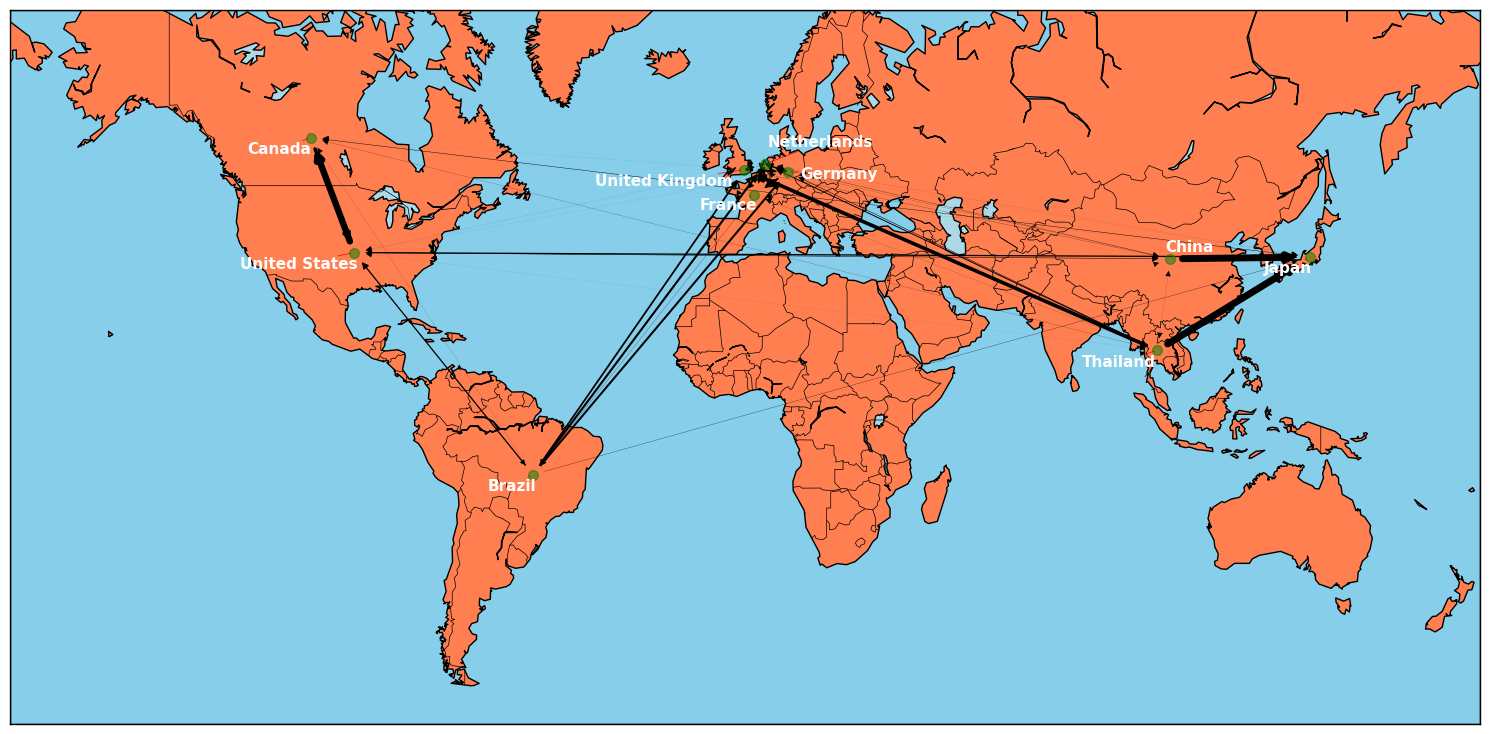

In [175]:
# Assuming 'graphs' is already defined as before
commodity = 'Meat, prepared or preserved'
G = graphs[commodity]

# Define country information
countries_df = pd.DataFrame({
    'Country': ['China', 'France', 'United Kingdom', 'Germany', 'Japan', 'Thailand', 'United States', 'Brazil', 'Netherlands', 'Canada'],
    'Latitude': [35.8617, 47.5162, 51.5074, 51.1657, 36.2048, 15.8700, 37.0902, -14.2350, 52.3676, 56.1304],
    'Longitude': [104.1954, 2.2430, -0.1276, 10.4515, 138.2529, 100.9925, -95.7129, -51.9253, 4.9041, -106.3468]
})

# Calculate in-degree centrality
in_degree_centrality = nx.in_degree_centrality(G)

# Calculate out-degree centrality
out_degree_centrality = nx.out_degree_centrality(G)

# Combine in-degree and out-degree centrality to get total centrality
total_centrality = {country: in_degree_centrality[country] + out_degree_centrality[country] for country in countries_df['Country']}

# Select top 10 countries by total centrality
top_countries_by_centrality = sorted(total_centrality.items(), key=lambda item: item[1], reverse=True)[:15]

# Filter the graph G to include only nodes from top_countries
H = G.subgraph([country for country, _ in top_countries_by_centrality])

# Ensure there are edges and calculate the max weight
if H.edges():
    max_weight = max(edge[2]['weight'] for edge in H.edges(data=True))
    if max_weight > 0:
        # Proceed with visualization

        # Create a base world map
        fig, ax = plt.subplots(figsize=(15, 8))
        m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=70, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c', lon_0=0)
        m.drawcountries()
        m.drawmapboundary(fill_color='skyblue')
        m.fillcontinents(color='coral', lake_color='lightblue')
        m.drawcoastlines()

        # Positions for nodes corrected with Basemap's projection
        pos = {country: m(lon, lat) for country, lon, lat in zip(countries_df['Country'], countries_df['Longitude'], countries_df['Latitude']) if country in H.nodes()}

        # Draw nodes on the world map
        nx.draw_networkx_nodes(H, pos, node_size=50, node_color='green', alpha=0.5, ax=ax)

        # Draw edges with weights (trade volumes)
        for edge in H.edges(data=True):
            weight = edge[2]['weight']
            scaled_weight = weight / max_weight * 5  # Adjust 5 to scale for better visibility if needed
            nx.draw_networkx_edges(H, pos, edgelist=[(edge[0], edge[1])], width=scaled_weight, edge_color='black', ax=ax)

        # Initialize texts for adjust_text
        texts = []
        for node, (x, y) in pos.items():
            texts.append(plt.text(x, y, node, fontsize=11, ha='center', va='center', color='white', weight='bold'))

        # Use adjust_text to optimize label placement
        adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='->', color='r', lw=0.5))
        
        plt.tight_layout()
        plt.show()
    else:
        print("The maximum weight in the subgraph is zero, can't scale the edge widths.")
else:
    print("No edges to display.")

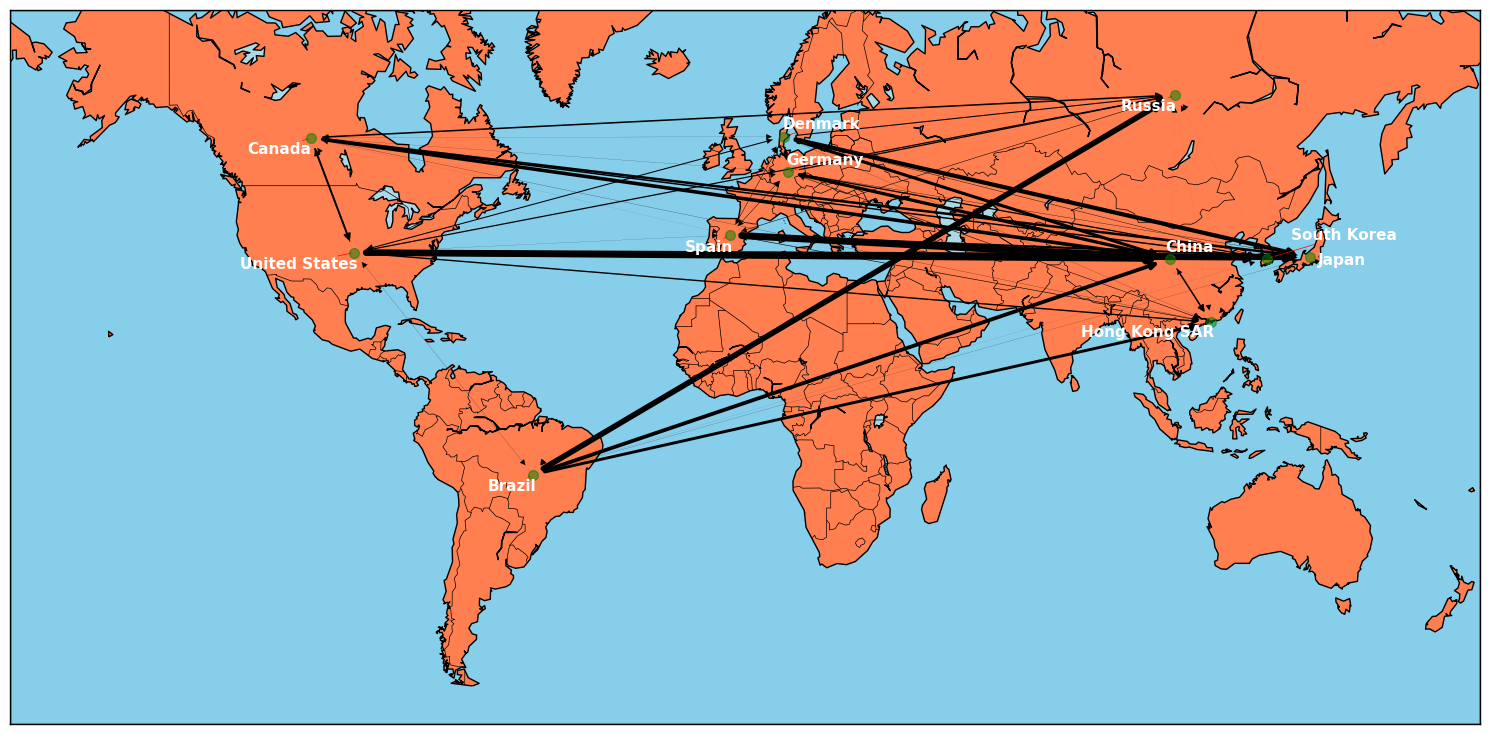

In [177]:
# Assuming 'graphs' is already defined as before
commodity = 'Pork frozen'
G = graphs[commodity]

# Define country information
countries_df = pd.DataFrame({
    'Country': ['China', 'Japan', 'Russia', 'South Korea', 'Denmark', 'Spain', 'United States', 'Brazil', 'Germany', 'Hong Kong SAR', 'Canada'],
    'Latitude': [35.8617, 36.2048, 61.5240, 35.9078, 56.2639, 40.4637, 37.0902, -14.2350, 51.1657, 22.3193, 56.1304],
    'Longitude': [104.1954, 138.2529, 105.3188, 127.7669, 9.5018, -3.7492, -95.7129, -51.9253, 10.4515, 114.1694, -106.3468]
})


# Calculate in-degree centrality
in_degree_centrality = nx.in_degree_centrality(G)

# Calculate out-degree centrality
out_degree_centrality = nx.out_degree_centrality(G)

# Combine in-degree and out-degree centrality to get total centrality
total_centrality = {country: in_degree_centrality[country] + out_degree_centrality[country] for country in countries_df['Country']}

# Select top 10 countries by total centrality
top_countries_by_centrality = sorted(total_centrality.items(), key=lambda item: item[1], reverse=True)[:15]

# Filter the graph G to include only nodes from top_countries
H = G.subgraph([country for country, _ in top_countries_by_centrality])

# Ensure there are edges and calculate the max weight
if H.edges():
    max_weight = max(edge[2]['weight'] for edge in H.edges(data=True))
    if max_weight > 0:
        # Proceed with visualization

        # Create a base world map
        fig, ax = plt.subplots(figsize=(15, 8))
        m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=70, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c', lon_0=0)
        m.drawcountries()
        m.drawmapboundary(fill_color='skyblue')
        m.fillcontinents(color='coral', lake_color='lightblue')
        m.drawcoastlines()

        # Positions for nodes corrected with Basemap's projection
        pos = {country: m(lon, lat) for country, lon, lat in zip(countries_df['Country'], countries_df['Longitude'], countries_df['Latitude']) if country in H.nodes()}

        # Draw nodes on the world map
        nx.draw_networkx_nodes(H, pos, node_size=50, node_color='green', alpha=0.5, ax=ax)

        # Draw edges with weights (trade volumes)
        for edge in H.edges(data=True):
            weight = edge[2]['weight']
            scaled_weight = weight / max_weight * 5  # Adjust 5 to scale for better visibility if needed
            nx.draw_networkx_edges(H, pos, edgelist=[(edge[0], edge[1])], width=scaled_weight, edge_color='black', ax=ax)

        # Initialize texts for adjust_text
        texts = []
        for node, (x, y) in pos.items():
            texts.append(plt.text(x, y, node, fontsize=11, ha='center', va='center', color='white', weight='bold'))

        # Use adjust_text to optimize label placement
        adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='->', color='r', lw=0.5))

        plt.tight_layout()
        plt.show()
    else:
        print("The maximum weight in the subgraph is zero, can't scale the edge widths.")
else:
    print("No edges to display.")


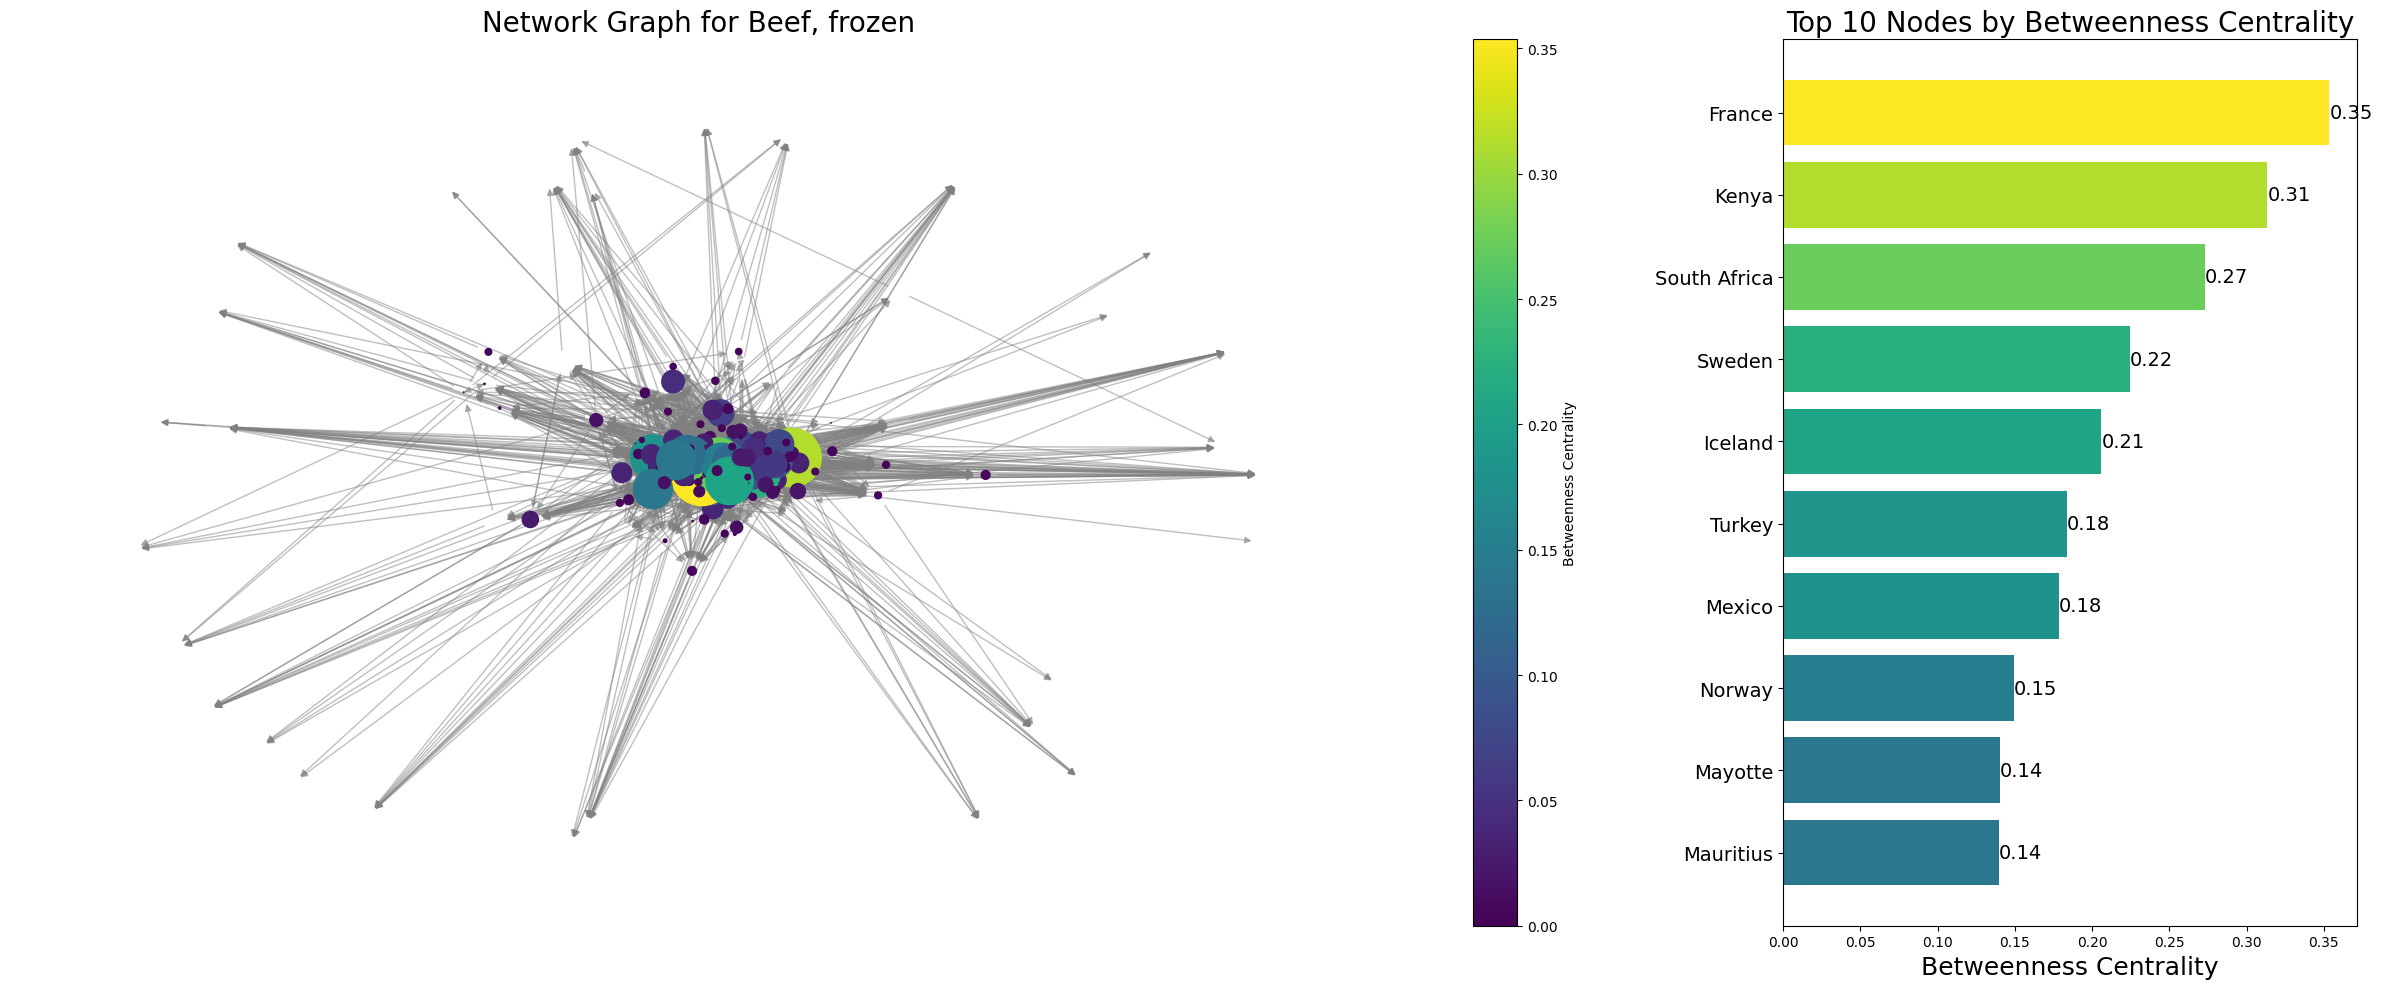

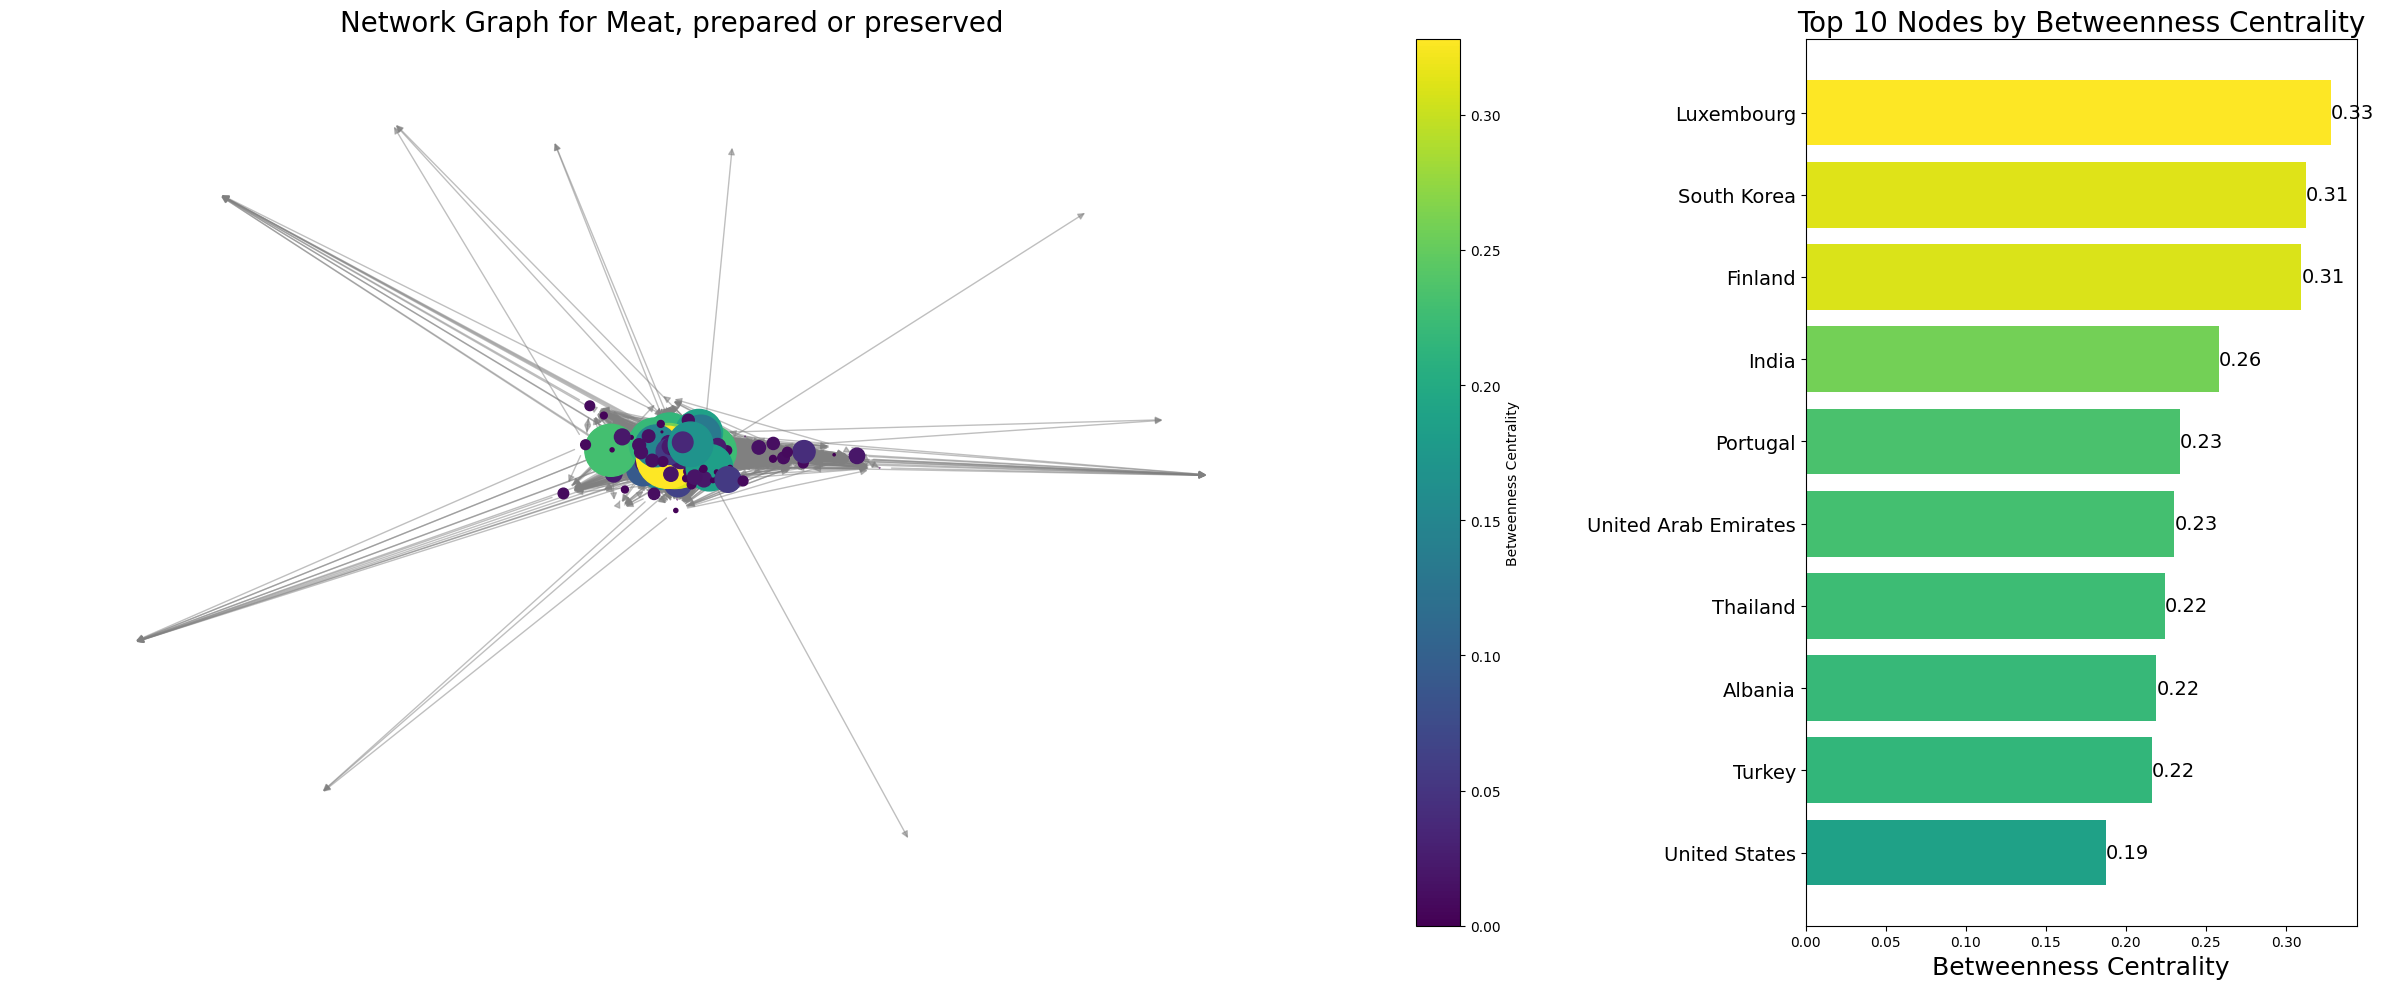

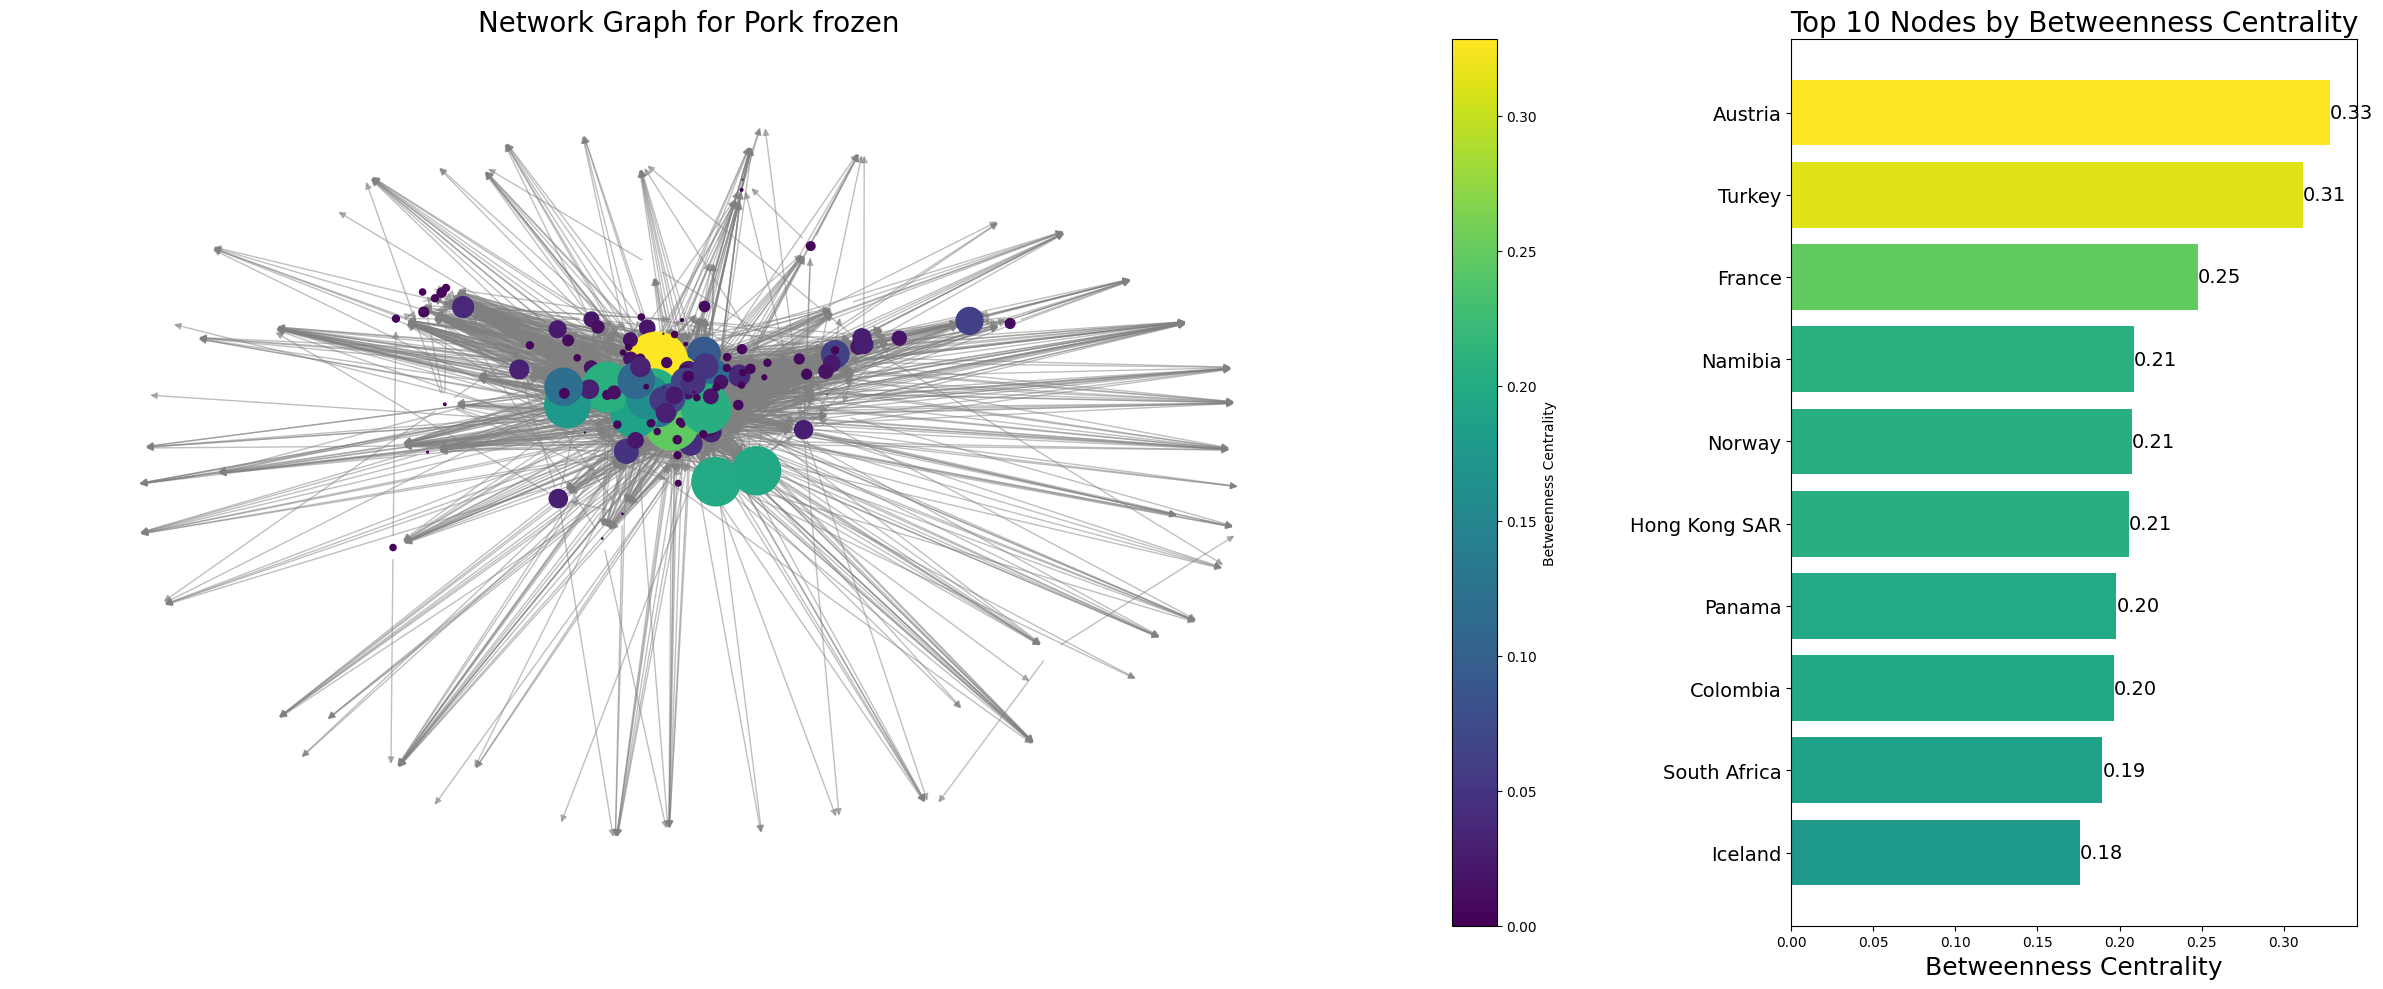

In [230]:
def draw_network_with_colored_bars(G, betweenness_centrality, title=''):
    # Create figure and axes for subplots
    fig, (ax_net, ax_bar) = plt.subplots(1, 2, figsize=(24, 10), gridspec_kw={'width_ratios': [3, 1]})
    
    # Network Graph
    # Normalize the betweenness centrality scores for color mapping
    max_centrality = max(betweenness_centrality.values())
    node_color = [betweenness_centrality.get(node, 0) for node in G]
    node_size = [v / max_centrality * 2000 for v in node_color]  # Scale node size by centrality
    pos = nx.spring_layout(G, seed=42, weight=None, iterations=50)
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, cmap='viridis', ax=ax_net)
    edges = nx.draw_networkx_edges(G, pos, ax=ax_net, edge_color='gray', alpha=0.5)

    # Color bar for the network graph
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=max_centrality))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax_net)
    cbar.set_label('Betweenness Centrality')

    # Set the title for the network graph
    ax_net.set_title(f'Network Graph for {title}', size=20)
    ax_net.axis('off')

    # Bar Chart
    # Get top 10 nodes by betweenness centrality
    top_nodes = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)[:10]
    nodes, values = zip(*top_nodes)
    
    y_pos = np.arange(len(nodes))
    colors = [plt.cm.viridis(value / max_centrality) for value in values]
    bars = ax_bar.barh(y_pos, values, color=colors)
    ax_bar.set_yticks(y_pos)
    ax_bar.set_yticklabels(nodes, fontsize=14)
    ax_bar.invert_yaxis()  # labels read top-to-bottom
    ax_bar.set_xlabel('Betweenness Centrality', fontsize=18)
    ax_bar.set_title('Top 10 Nodes by Betweenness Centrality', fontsize=20)
    
    for bar, value in zip(bars, values):
        ax_bar.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f"{value:.2f}",
                    va='center', ha='left', fontsize=14, color='black')

    plt.tight_layout()
    plt.show()

# Example usage:
for commodity, G in graphs.items():
    betweenness_centrality = nx.betweenness_centrality(G, weight='weight', normalized=True)
    draw_network_with_colored_bars(G, betweenness_centrality, title=commodity)


**Cluster Analysis**

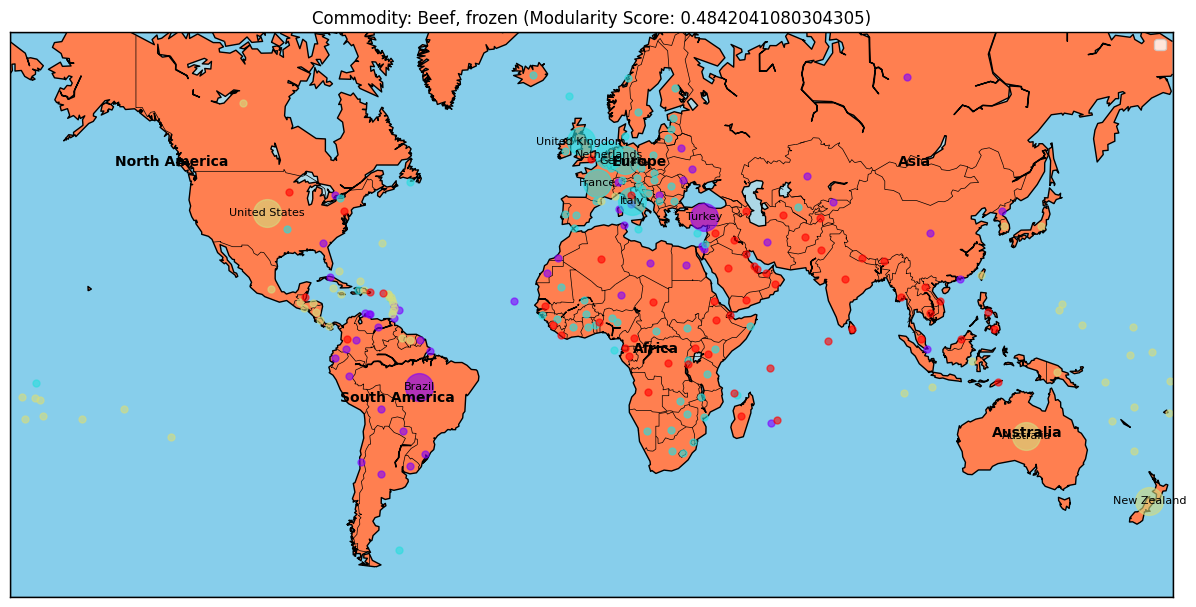

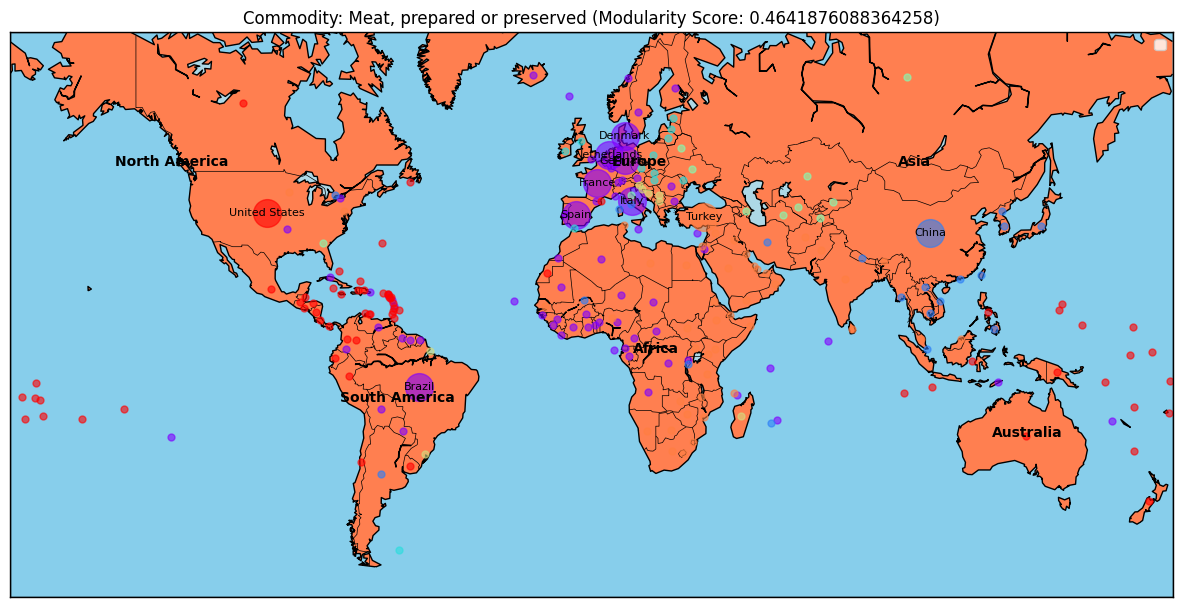

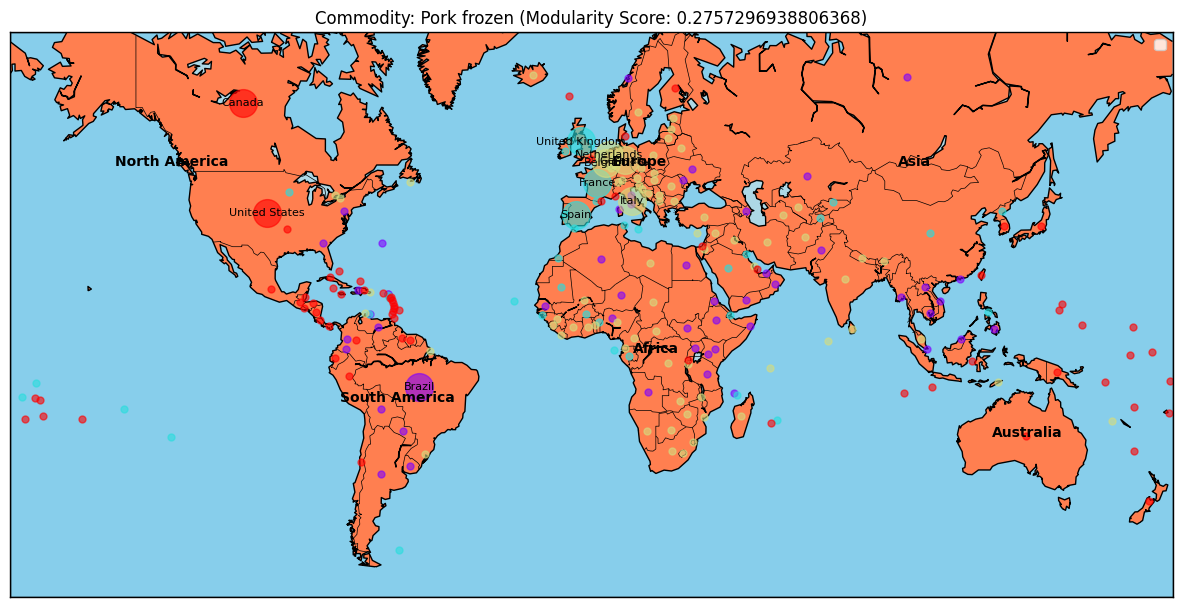

In [227]:

# Initialize geolocator
geolocator = Nominatim(user_agent="geoapiExercises")

# Example list of countries
countries = ['Cayman Islands', 'St Lucia', 'Guatemala', 'Nicaragua', 'South Korea', 'Japan', 'Canada', 'Honduras', 'Papua New Guinea', 'Belize', 'Dominica', 'Norfolk Island', 'Solomon Islands', 'St Vincent and the Grenadines', 'US Miscellaneous Pacific Islands', 'Taiwan', 'British Virgin Islands', 'Guadeloupe', 'Thailand', 'United States', 'San Marino', 'Guam', 'Tonga', 'American Samoa', 'Cambodia', 'Wallis and Futuna Islands', 'Marshall Islands', 'Western Samoa', 'Nauru', 'St Maarten', 'Northern Mariana Islands', 'Pitcairn Island', 'Fiji', 'New Zealand', 'Suriname', 'Antigua and Barbuda', 'Jamaica', 'Cook Islands', 'Australia', 'East Timor', 'Niue', 'Panama', 'Christmas Island', 'Barbados', 'Laos', 'Dominican Republic', 'Bermuda', 'Grenada', 'Micronesia', 'Monaco', 'Bahamas', 'New Caledonia', 'El Salvador', 'Kiribati', 'Guyana', 'Cocos (Keeling) Islands', 'Costa Rica', 'Tuvalu', 'Turks and Caicos Islands', 'Indonesia', 'Vanuatu', 'Tokelau', 'St Kitts and Nevis', 'Mexico', 'Palau', 'Anguilla', 'Estonia', 'Burkina Faso', 'Poland', 'Austria', 'Greenland', 'Switzerland', 'Malta', 'St Barthélemy', 'Macedonia, North', 'Belgium', 'Sudan', 'Kosovo', 'Mayotte', 'United Kingdom', 'Bulgaria', 'Slovenia', 'Ireland', 'St Pierre and Miquelon', 'Croatia', 'Guinea', 'West Bank', 'Djibouti', 'Denmark', 'Central African Republic', 'Ghana', 'Sweden', 'Faroe Islands', 'Finland', 'Lithuania', 'Italy', 'Mauritania', 'Latvia', 'Liechtenstein', 'Andorra', 'Netherlands', 'São Tomé and Príncipe', 'Guinea-Bissau', 'Falkland Islands', 'France', 'Gibraltar', 'Chad', 'Slovakia', 'Greece', 'Mali', 'Germany', 'Rest of America, nes.', 'Spain', 'Czechia', 'Haiti', 'Iceland', 'Bosnia and Herzegovina', 'Cyprus', 'Hungary', 'Portugal', 'Bonaire, Saint Eustatius and Saba', 'Luxembourg', 'Uzbekistan', 'Romania',  'Bangladesh', 'Benin', 'Turkmenistan', 'Tajikistan', 'Equatorial Guinea', 'Sierra Leone', 'Jordan', 'Yemen', 'Madagascar', 'Bhutan', 'Kuwait', 'Bahrain', 'Brunei', 'Azerbaijan', 'Afghanistan', 'Gabon', 'Gambia, The', 'Montserrat', 'Senegal', 'Burundi', 'Myanmar', 'Armenia', 'Syria', 'Malaysia', 'Sri Lanka', 'Saudi Arabia', 'Angola', 'Uganda', 'Congo, Republic of the', "Côte d'Ivoire", 'Qatar', 'Comoros', 'India', 'Nepal', 'Mauritius', 'Pakistan', 'Algeria', 'Maldives', 'Lebanon', 'Iraq', 'Vietnam', 'Philippines', 'Oman', 'Liberia', 'Cameroon',  'Vatican City', 'Togo', 'Netherlands Antilles', 'British Indian Ocean Territories', 'Montenegro', 'North Korea', 'Réunion', 'Chile', 'Aruba', 'French Polynesia', 'Moldova', 'Bolivia', 'Cuba', 'United Arab Emirates', 'Tunisia', 'Ecuador', 'Georgia', 'Belarus', 'Serbia', 'Mongolia', 'Brazil', 'Western Sahara', 'Uruguay', 'Trinidad and Tobago', 'Cape Verde', 'Macao SAR', 'Egypt', 'Morocco', 'Paraguay', 'Eritrea', 'Curacao', 'Libya', 'St. Martin Island (North Part)', 'Argentina', 'Ukraine', 'Peru', 'Hong Kong SAR', 'Iran', 'French Guiana', 'Israel', 'Albania', 'Venezuela', 'Martinique', 'Kazakhstan', 'Kyrgyzstan', 'Turkey', 'Colombia', 'Niger', 'Caribbean', 'Russia', 'Gaza Strip', 'China', 'Singapore', 'Zambia', 'South Africa', 'South Sudan', 'St Helena, Ascension and Tristan da Cunha', 'Zimbabwe', 'Rwanda', 'Congo, D.R.', 'Lesotho', 'Norway', 'Mozambique', 'Ethiopia', 'Botswana', 'Namibia', 'Malawi', 'Seychelles', 'Nigeria', 'Eswatini', 'Tanzania', 'Kenya', 'Somalia']
positions = {}

continent_positions = {
    'North America': (-130, 50),
    'South America': (-60, -15),
    'Europe': (15, 50),
    'Asia': (100, 50),
    'Africa': (20, 0),
    'Australia': (135, -25),
}

# Get latitude and longitude for each country
for country in countries:
    location = geolocator.geocode(country)
    if location:
        positions[country] = (location.longitude, location.latitude)

for commodity, graph in graphs.items():
    # Compute out-degree centrality for the current commodity's graph
    out_degree_centrality = nx.out_degree_centrality(graph)

     # Sort nodes by out-degree centrality and get top 10
    top_nodes = sorted(out_degree_centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
    top_nodes = [node for node, centrality in top_nodes]

    # Detecting communities
    communities = nx_comm.louvain_communities(graph, weight='weight')
    modularity_score = nx_comm.modularity(graph, communities, weight='weight')
    
    # Create a base world map
    fig, ax = plt.subplots(figsize=(15, 8))
    m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=70, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c', lon_0=0)
    m.drawcountries()
    m.drawmapboundary(fill_color='skyblue')
    m.fillcontinents(color='coral', lake_color='lightblue')
    m.drawcoastlines()
    
    # Color mapping for communities
    community_colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))
    dark_community_colors = [(r, g, b, 0.6) for r, g, b, a in community_colors]

    # Plot each community with its own color
    for community_num, community in enumerate(communities):
        color = dark_community_colors[community_num]
        for country in community:
            if country in positions:
                x, y = m(*positions[country])
                if country in top_nodes:
                    m.plot(x, y, 'o', color=color, markersize=20)  # Make top nodes bigger
                    plt.text(x, y, country, fontsize=8, ha='center', va='center', color='black')
                else:
                    m.plot(x, y, 'o', color=color, markersize=5)
    # Label continents on the map
    for continent, pos in continent_positions.items():
        x, y = m(pos[0], pos[1])
        plt.text(x, y, continent, fontsize=10, ha='center', color='black', fontweight='bold')

    # Avoid duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    # Add title and show the plot
    plt.title(f'Commodity: {commodity} (Modularity Score: {modularity_score})')
    plt.show()


In [275]:
def format_volume(x):
    return "{:,.2f} million tons".format(x)

def get_top_nodes_by_out_degree(graph, top_n=20):
    out_degree_centrality = nx.out_degree_centrality(graph)
    top_nodes = sorted(out_degree_centrality.items(), key=lambda item: item[1], reverse=True)[:top_n]
    return [node for node, _ in top_nodes]

def simulate_shock(graph, node_to_remove):
    # Returns simulation results even if node is not in the graph
    if node_to_remove not in graph:
        return {
            'is_disconnected': False,
            'affected_countries': {},
            'total_trade_lost': 0
        }

    G_simulated = graph.copy()
    connected_edges = list(G_simulated.edges(node_to_remove, data=True))
    affected_countries = {}
    for edge in connected_edges:
        country = edge[1] if edge[0] == node_to_remove else edge[0]
        volume = edge[2].get('weight', 0)
        affected_countries[country] = affected_countries.get(country, 0) + volume

    G_simulated.remove_node(node_to_remove)
    is_disconnected = nx.number_connected_components(G_simulated.to_undirected()) > 1
    total_trade_lost = sum(affected_countries.values())

    return {
        'is_disconnected': is_disconnected,
        'affected_countries': affected_countries,
        'total_trade_lost': total_trade_lost
    }

def perform_commodity_shock_tests(graph, top_nodes):
    results = {}
    for node_to_remove in top_nodes:
        results[node_to_remove] = simulate_shock(graph, node_to_remove)
    return results

def aggregate_and_format_results(shock_results):
    data = []
    for node_removed, result in shock_results.items():
        if 'affected_countries' in result:
            for country, volume_loss in result['affected_countries'].items():
                # Store volume loss in billions directly
                data.append({
                    'node_removed': node_removed,
                    'country': country,
                    'volume_loss': volume_loss / 1_000_000  # Convert to millions
                })
        else:
            print(f"Unexpected result structure for {node_removed}: {result}")
    df = pd.DataFrame(data)
    
    # First, sort the DataFrame by 'volume_loss' before formatting
    df_sorted = df.sort_values(by='volume_loss', ascending=False)
    
    df_sorted['volume_loss'] = df_sorted['volume_loss'].apply(format_volume)
    return df_sorted

# Example usage with assumed correct 'shock_results' input
shock_results = perform_commodity_shock_tests(graph, get_top_nodes_by_out_degree(graph))
aggregated_data = aggregate_and_format_results(shock_results)

print(aggregated_data.head(20))  



       node_removed        country        volume_loss
701           Spain          China  3.67 million tons
81    United States          Japan  3.37 million tons
29    United States          China  3.31 million tons
471          Brazil         Russia  2.98 million tons
1539        Denmark          Japan  2.23 million tons
145   United States    South Korea  2.22 million tons
380          Brazil          China  2.00 million tons
841          Canada          China  1.89 million tons
546         Germany          China  1.71 million tons
1500        Denmark          China  1.64 million tons
415          Brazil  Hong Kong SAR  1.54 million tons
880          Canada          Japan  1.33 million tons
744           Spain          Japan  1.15 million tons
205     Netherlands          China  1.12 million tons
950          Canada  United States  1.02 million tons
8     United States      Australia  0.90 million tons
919          Canada         Russia  0.82 million tons
2318          China  Hong Ko

/var/folders/j7/2lrdjst10q78p02rxh29kpxc0000gn/T/ipykernel_7666/3079981061.py:35: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


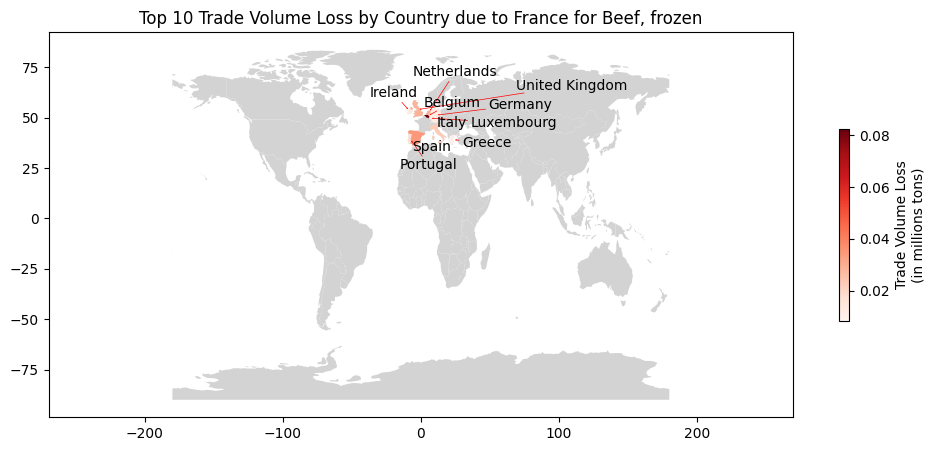

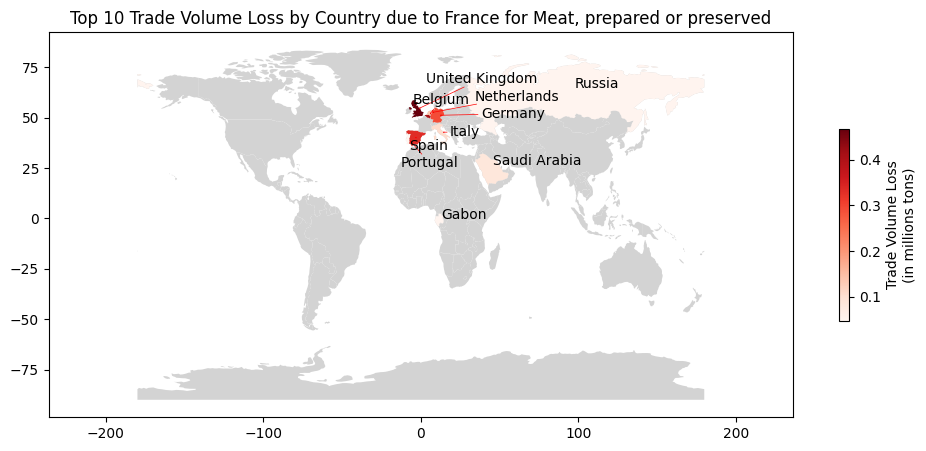

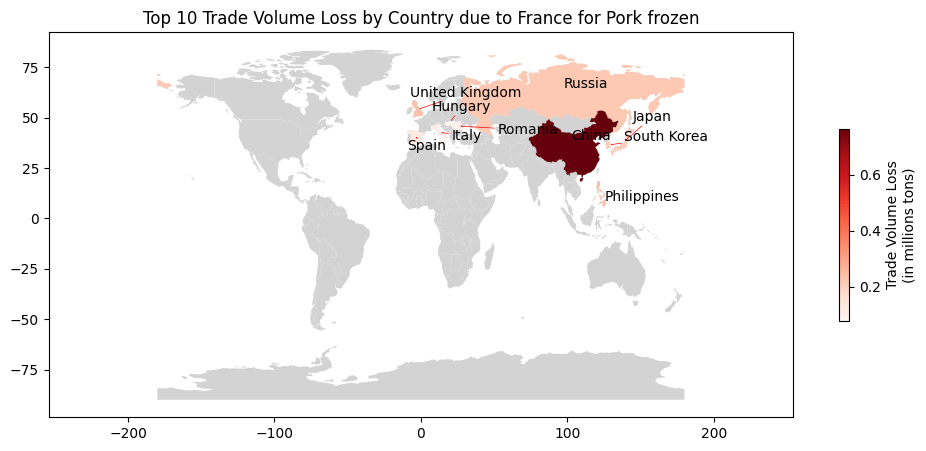

In [273]:
def wrap_text(text, width):
    # Wrap text with a specified character width.
    import textwrap
    return '\n'.join(textwrap.wrap(text, width))

def perform_commodity_shock_tests(graphs, node_to_remove):
    """ Perform shock tests for each commodity graph, including trade volume analysis. """
    results = {}
    for commodity, graph in graphs.items():
        result = simulate_shock(graph, node_to_remove)
        results[commodity] = result
    return results

# Rerun this with the correct node_to_remove and graph data
node_to_remove = 'France'
shock_results = perform_commodity_shock_tests(graphs, node_to_remove)

def aggregate_results(shock_results):
    data = []
    for commodity, results in shock_results.items():
        for country, volume_loss in results['affected_countries'].items():
            data.append({
                'commodity': commodity,
                'country': country,
                'volume_loss': volume_loss/ 1_000_000
            })

    return pd.DataFrame(data)

aggregated_commodity_data = aggregate_results(shock_results)

def plot_affected_countries_by_commodity(data_frame):
    """ Plots affected countries with trade volume reduction on a world map by commodity, labeling only the top 10 by volume loss. """
    # Load world map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    # Iterate over each commodity
    for commodity in data_frame['commodity'].unique():
        fig, ax = plt.subplots(1, figsize=(12, 5))
        world.plot(ax=ax, color='lightgrey')  
        ax.set_aspect('equal', adjustable='datalim')

        # Filter data for the current commodity and sort by volume loss
        commodity_data = data_frame[data_frame['commodity'] == commodity]
        commodity_data = commodity_data.sort_values(by='volume_loss', ascending=False).head(10)

        # Merge the world map with the top 10 commodity data
        commodity_world = world.merge(commodity_data, how='left', left_on='name', right_on='country')

        # Define the legend label with wrapped text
        legend_label = wrap_text(f"Trade Volume Loss             (in millions tons)", 30)
        
        # Plotting affected countries with trade volume reduction
        plot = commodity_world.dropna(subset=['volume_loss']).plot(ax=ax, column='volume_loss', cmap='Reds', legend=True,
                                                                    legend_kwds={'label': legend_label,
                                                                                'orientation': "vertical",
                                                                                'shrink': 0.5,})
        
        # Label the top 10 affected countries
        texts = []
        for idx, row in commodity_world.dropna(subset=['volume_loss']).iterrows():
            x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
            text = ax.text(x, y, row['name'], fontsize=10)
            texts.append(text)
        
        # Adjust text to avoid overlap
        adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="->", color='red', lw=0.5))
        
        plt.title(f'Top 10 Trade Volume Loss by Country due to {node_to_remove} for {commodity}')
        plt.show()

# Assuming you have the shock_results variable from the perform_commodity_shock_tests function
plot_affected_countries_by_commodity(aggregated_commodity_data)





Commodity: Beef, frozen - Simulation completed. Volume loss due to Infection: 60356503.86, Policy: 252124.91, Disruptions: 17615150.20
Commodity: Meat, prepared or preserved - Simulation completed. Volume loss due to Infection: 64832425.57, Policy: 908548.54, Disruptions: 10281197.68
Commodity: Pork frozen - Simulation completed. Volume loss due to Infection: 66336626.67, Policy: 2021068.14, Disruptions: 37470108.99
Commodity: Beef, frozen - Simulation completed. Volume loss due to Infection: 59021503.65, Policy: 808376.22, Disruptions: 1014387.40
Commodity: Meat, prepared or preserved - Simulation completed. Volume loss due to Infection: 62661100.73, Policy: 1626732.47, Disruptions: 2250530.58
Commodity: Pork frozen - Simulation completed. Volume loss due to Infection: 60058303.94, Policy: 113274.89, Disruptions: 590372.79
Commodity: Beef, frozen - Simulation completed. Volume loss due to Infection: 60030867.81, Policy: 344235.40, Disruptions: 972431.15
Commodity: Meat, prepared or pr

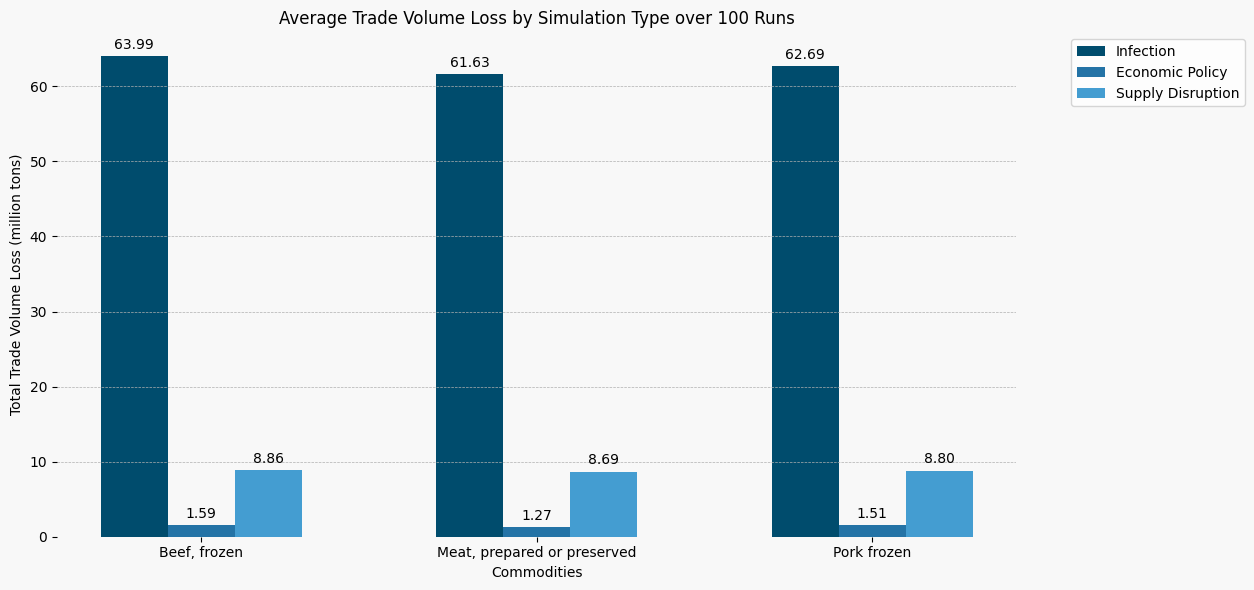

In [247]:

def capture_initial_volumes(graph):
    """Capture the initial trade volumes for each edge in the graph."""
    for u, v, data in graph.edges(data=True):
        data['initial_weight'] = data.get('weight', 0)

def simulate_infection(graph, alpha=2, beta_param=5):
    """Simulate infection impacts using a beta distribution for workforce availability."""
    infection_rates = {node: beta.rvs(alpha, beta_param) for node in graph.nodes()}
    for u, v, data in graph.edges(data=True):
        data['weight'] *= (infection_rates[u] + infection_rates[v]) / 2

def simulate_economic_policies(graph, policy_range=(0.8, 1.2)):
    """Adjust trade volumes based on random economic policy effectiveness."""
    for node in graph.nodes():
        policy_effect = uniform.rvs(*policy_range)
        for u, v, data in graph.out_edges(node, data=True):
            data['weight'] *= policy_effect

def simulate_supply_disruptions(graph, disruption_prob=0.1):
    """Introduce random failures in the supply chain."""
    for node in graph.nodes():
        if np.random.rand() < disruption_prob:
            for u, v, data in graph.out_edges(node, data=True):
                data['weight'] = 0

def calculate_volume_loss(graph, initial_volumes):
    """Calculate the trade volume loss based on initial volumes."""
    loss = 0
    for (u, v), initial in initial_volumes.items():
        current = graph[u][v]['weight']
        loss += max(0, initial - current)  # Ensure no negative losses
    return loss

def perform_independent_stochastic_simulation(graphs):
    results = {}
    
    for commodity, original_graph in graphs.items():
        # Make a deep copy of the graph to retain the original state
        graph = copy.deepcopy(original_graph)
        initial_volumes = nx.get_edge_attributes(graph, 'weight')

        # Simulate infection
        simulate_infection(graph)
        infection_loss = calculate_volume_loss(graph, initial_volumes)
        
        # Reset graph to original state before next simulation
        graph = copy.deepcopy(original_graph)

        # Simulate economic policies
        simulate_economic_policies(graph)
        policy_loss = calculate_volume_loss(graph, initial_volumes)
        
        # Reset graph to original state before next simulation
        graph = copy.deepcopy(original_graph)

        # Simulate supply disruptions
        simulate_supply_disruptions(graph)
        disruption_loss = calculate_volume_loss(graph, initial_volumes)

        results[commodity] = {
            'infection_loss': infection_loss,
            'policy_loss': policy_loss,
            'disruption_loss': disruption_loss
        }
        
        print(f"Commodity: {commodity} - Simulation completed. Volume loss due to Infection: {infection_loss:.2f}, Policy: {policy_loss:.2f}, Disruptions: {disruption_loss:.2f}")

    return results

def perform_multiple_stochastic_simulations(graphs, num_runs=100):
    all_results = {commodity: {'infection_losses': [], 'policy_losses': [], 'disruption_losses': []} for commodity in graphs}

    for _ in range(num_runs):
        single_run_results = perform_independent_stochastic_simulation(graphs)
        for commodity, result in single_run_results.items():
            all_results[commodity]['infection_losses'].append(result['infection_loss'])
            all_results[commodity]['policy_losses'].append(result['policy_loss'])
            all_results[commodity]['disruption_losses'].append(result['disruption_loss'])

    average_results = {commodity: {} for commodity in graphs}
    for commodity, results in all_results.items():
        average_results[commodity]['avg_infection_loss'] = np.mean(results['infection_losses'])
        average_results[commodity]['avg_policy_loss'] = np.mean(results['policy_losses'])
        average_results[commodity]['avg_disruption_loss'] = np.mean(results['disruption_losses'])

    return average_results

def plot_grouped_trade_volume_loss(results):
    """Plot the trade volume loss grouped by type of simulation."""
    commodities = list(results.keys())
    # Access the results with the 'avg_' prefix
    infection_losses = [res['avg_infection_loss']/1e6 for res in results.values()]  # Convert to million tons
    policy_losses = [res['avg_policy_loss']/1e6 for res in results.values()]  # Convert to million tons
    disruption_losses = [res['avg_disruption_loss']/1e6 for res in results.values()]  # Convert to million tons

    x = np.arange(len(commodities))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(15, 6)) 
    # Define the colors to match the infographic
    colors = ['#004c6d', '#2473a6', '#449dd1']
    rects1 = ax.bar(x - width, infection_losses, width, label='Infection', color=colors[0])
    rects2 = ax.bar(x, policy_losses, width, label='Economic Policy', color=colors[1])
    rects3 = ax.bar(x + width, disruption_losses, width, label='Supply Disruption', color=colors[2])

    # Customize the plot to match the infographic
    ax.set_xlabel('Commodities')
    ax.set_ylabel('Total Trade Volume Loss (million tons)')
    ax.set_title('Average Trade Volume Loss by Simulation Type over 100 Runs')
    ax.set_xticks(x)
    ax.set_xticklabels(commodities)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add labels on top of the bars
    ax.bar_label(rects1, padding=3, fmt='%.2f')
    ax.bar_label(rects2, padding=3, fmt='%.2f')
    ax.bar_label(rects3, padding=3, fmt='%.2f')

    # Style to match the infographic
    ax.set_facecolor('#f8f8f8')  # Light grey background
    ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)
    fig.set_facecolor('#f8f8f8')
    for spine in ax.spines.values():
        spine.set_visible(False)

    fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to make room for the legend
    plt.show()

detailed_simulation_results = perform_independent_stochastic_simulation(graphs)
average_simulation_results = perform_multiple_stochastic_simulations(graphs, num_runs=100)
plot_grouped_trade_volume_loss(average_simulation_results)
